In [ ]:
from google.colab import drive
drive.mount('/content.drive')

Mounted at /content.drive


In [ ]:
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, BatchNormalization, Dropout, Conv2D, concatenate, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from keras import backend as K
from keras.layers.core import SpatialDropout2D
from keras.optimizers import Adam, SGD
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

from sklearn.model_selection import train_test_split
from warnings import filterwarnings

filterwarnings('ignore')
plt.rcParams["axes.grid"] = False
np.random.seed(101)

In [ ]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [ ]:

filelist_trainx_ph2 = sorted(glob.glob('/content.drive/MyDrive/colondataset/x_train/*.png'), key=numericalSort)
X_train_ph2 = np.array([np.array(Image.open(fname)) for fname in filelist_trainx_ph2])

filelist_trainy_ph2 = sorted(glob.glob('/content.drive/MyDrive/colondataset/y_train/*.png'), key=numericalSort)
Y_train_ph2 = np.array([np.array(Image.open(fname)) for fname in filelist_trainy_ph2])

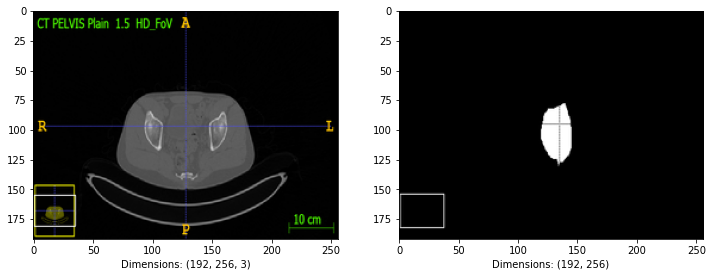

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(X_train_ph2[0])
plt.xlabel("Dimensions: "+str(np.array(X_train_ph2[0]).shape))
plt.subplot(1,2,2)
plt.imshow(Y_train_ph2[0], plt.cm.binary_r)
plt.xlabel("Dimensions: "+str(np.array(Y_train_ph2[0]).shape))
plt.show()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_train_ph2, Y_train_ph2, test_size = 0.25, random_state = 101)

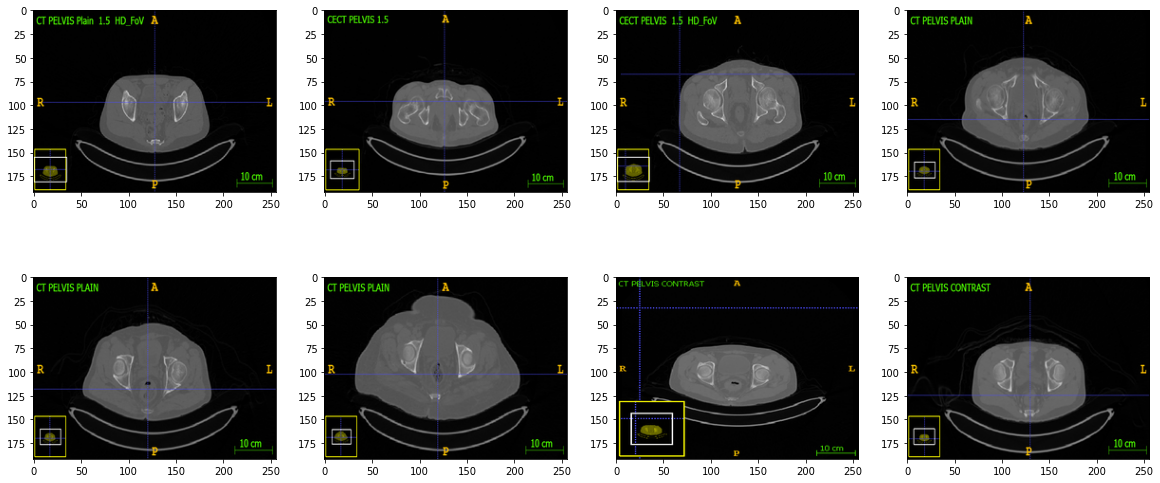

In [ ]:
plt.figure(figsize=(20,9))
plt.subplot(2,4,1)
plt.imshow(X_train_ph2[0])
plt.subplot(2,4,2)
plt.imshow(X_train_ph2[3])
plt.subplot(2,4,3)
plt.imshow(X_train_ph2[54])
plt.subplot(2,4,4)
plt.imshow(X_train_ph2[77])
plt.subplot(2,4,5)
plt.imshow(X_train_ph2[100])
plt.subplot(2,4,6)
plt.imshow(X_train_ph2[125])
plt.subplot(2,4,7)
plt.imshow(X_train_ph2[130])
plt.subplot(2,4,8)
plt.imshow(X_train_ph2[149])
plt.show()

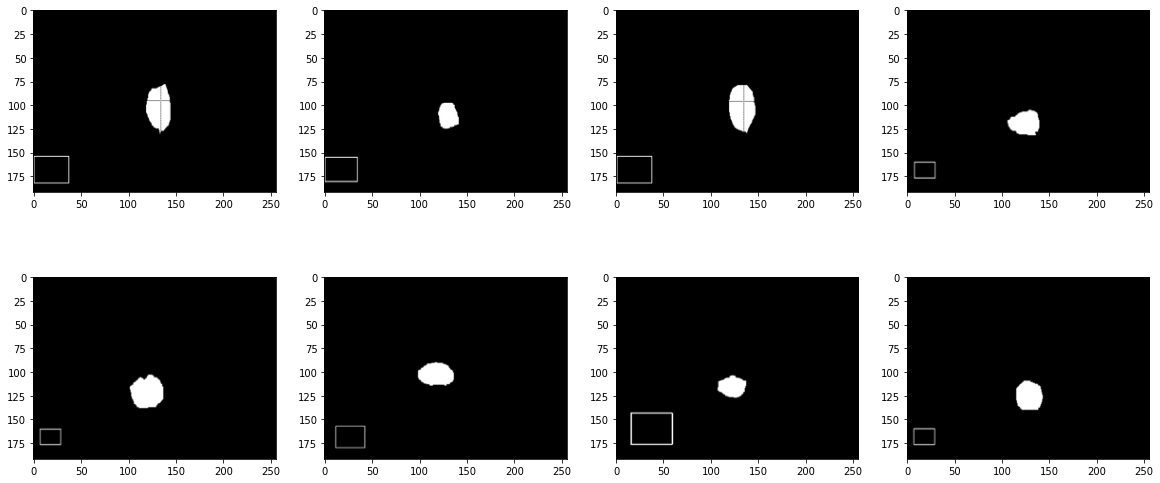

In [ ]:
plt.figure(figsize=(20,9))
plt.subplot(2,4,1)
plt.imshow(Y_train_ph2[0], cmap = plt.cm.binary_r)
plt.subplot(2,4,2)
plt.imshow(Y_train_ph2[3], cmap = plt.cm.binary_r)
plt.subplot(2,4,3)
plt.imshow(Y_train_ph2[54], cmap = plt.cm.binary_r)
plt.subplot(2,4,4)
plt.imshow(Y_train_ph2[77], cmap = plt.cm.binary_r)
plt.subplot(2,4,5)
plt.imshow(Y_train_ph2[100], cmap = plt.cm.binary_r)
plt.subplot(2,4,6)
plt.imshow(Y_train_ph2[125], cmap = plt.cm.binary_r)
plt.subplot(2,4,7)
plt.imshow(Y_train_ph2[130], cmap = plt.cm.binary_r)
plt.subplot(2,4,8)
plt.imshow(Y_train_ph2[149], cmap = plt.cm.binary_r)
plt.show()

In [ ]:
def jaccard_distance(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac)

def iou(y_true, y_pred, smooth = 100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def dice_coef(y_true, y_pred, smooth = 100):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def accuracy(y_true, y_pred):
    '''Calculates the mean accuracy rate across all predictions for binary
    classification problems.
    '''
    return K.mean(K.equal(y_true, K.round(y_pred)))

In [ ]:
def random_rotation(x_image, y_image):
    rows_x,cols_x, chl_x = x_image.shape
    rows_y,cols_y = y_image.shape
    rand_num = np.random.randint(-40,40)
    M1 = cv2.getRotationMatrix2D((cols_x/2,rows_x/2),rand_num,1)
    M2 = cv2.getRotationMatrix2D((cols_y/2,rows_y/2),rand_num,1)
    x_image = cv2.warpAffine(x_image,M1,(cols_x,rows_x))
    y_image = cv2.warpAffine(y_image.astype('float32'),M2,(cols_y,rows_y))
    return np.array(x_image), np.array(y_image.astype('int'))

def horizontal_flip(x_image, y_image):
    x_image = cv2.flip(x_image, 1)
    y_image = cv2.flip(y_image.astype('float32'), 1)
    return x_image, y_image.astype('int')

In [ ]:
def img_augmentation(x_train, y_train):
    x_rotat = []
    y_rotat = []
    x_flip = []
    y_flip = []
    for idx in range(len(x_train)):
        x,y = random_rotation(x_train[idx], y_train[idx])
        x_rotat.append(x)
        y_rotat.append(y)
        
        x,y = horizontal_flip(x_train[idx], y_train[idx])
        x_flip.append(x)
        y_flip.append(y)
        
    return np.array(x_rotat), np.array(y_rotat), np.array(x_flip), np.array(y_flip)

In [ ]:
x_rotated, y_rotated, x_flipped, y_flipped = img_augmentation(x_train, y_train)
x_rotated_t, y_rotated_t, x_flipped_t, y_flipped_t = img_augmentation(x_test, y_test)

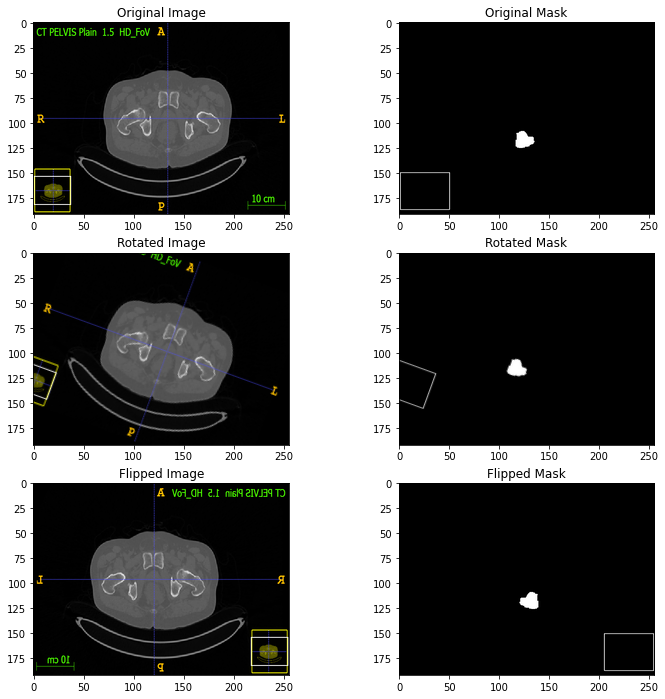

In [ ]:
img_num = 112
plt.figure(figsize=(12,12))
plt.subplot(3,2,1)
plt.imshow(x_train[img_num])
plt.title('Original Image')
plt.subplot(3,2,2)
plt.imshow(y_train[img_num], plt.cm.binary_r)
plt.title('Original Mask')
plt.subplot(3,2,3)
plt.imshow(x_rotated[img_num])
plt.title('Rotated Image')
plt.subplot(3,2,4)
plt.imshow(y_rotated[img_num], plt.cm.binary_r)
plt.title('Rotated Mask')
plt.subplot(3,2,5)
plt.imshow(x_flipped[img_num])
plt.title('Flipped Image')
plt.subplot(3,2,6)
plt.imshow(y_flipped[img_num], plt.cm.binary_r)
plt.title('Flipped Mask')
plt.show()

In [ ]:
x_train_full = np.concatenate([x_train, x_rotated, x_flipped])
y_train_full = np.concatenate([y_train, y_rotated, y_flipped])

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size = 0.20, random_state = 101)

In [ ]:
print("Length of the Training Set   : {}".format(len(x_train)))
print("Length of the Test Set       : {}".format(len(x_test)))
print("Length of the Validation Set : {}".format(len(x_val)))

Length of the Training Set   : 367
Length of the Test Set       : 52
Length of the Validation Set : 92


In [ ]:
#1 for grayscale images)
INPUT_CHANNELS = 3
# Number of output masks (1 in case you predict only one type of objects)
OUTPUT_MASK_CHANNELS = 1
# Pretrained weights

In [ ]:
def double_conv_layer(x, size, dropout=0.40, batch_norm=True):
    if K.image_data_format() == 'th':
        axis = 1
    else:
        axis = 3
    conv = Conv2D(size, (3, 3), padding='same')(x)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    conv = Conv2D(size, (3, 3), padding='same')(conv)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    if dropout > 0:
        conv = SpatialDropout2D(dropout)(conv)
    return conv


def UNET(epochs_num, savename):
    dropout_val=0.50
    if K.image_data_format() == 'th':
        inputs = Input((INPUT_CHANNELS, 192, 256))
        axis = 1
    else:
        inputs = Input((192, 256, INPUT_CHANNELS))
        axis = 3
    filters = 32

    conv_224 = double_conv_layer(inputs, filters)
    pool_112 = MaxPooling2D(pool_size=(2, 2))(conv_224)

    conv_112 = double_conv_layer(pool_112, 2*filters)
    pool_56 = MaxPooling2D(pool_size=(2, 2))(conv_112)

    conv_56 = double_conv_layer(pool_56, 4*filters)
    pool_28 = MaxPooling2D(pool_size=(2, 2))(conv_56)

    conv_28 = double_conv_layer(pool_28, 8*filters)
    pool_14 = MaxPooling2D(pool_size=(2, 2))(conv_28)

    conv_14 = double_conv_layer(pool_14, 16*filters)
    pool_7 = MaxPooling2D(pool_size=(2, 2))(conv_14)

    conv_7 = double_conv_layer(pool_7, 32*filters)

    up_14 = concatenate([UpSampling2D(size=(2, 2))(conv_7), conv_14], axis=axis)
    up_conv_14 = double_conv_layer(up_14, 16*filters)

    up_28 = concatenate([UpSampling2D(size=(2, 2))(up_conv_14), conv_28], axis=axis)
    up_conv_28 = double_conv_layer(up_28, 8*filters)

    up_56 = concatenate([UpSampling2D(size=(2, 2))(up_conv_28), conv_56], axis=axis)
    up_conv_56 = double_conv_layer(up_56, 4*filters)

    up_112 = concatenate([UpSampling2D(size=(2, 2))(up_conv_56), conv_112], axis=axis)
    up_conv_112 = double_conv_layer(up_112, 2*filters)

    up_224 = concatenate([UpSampling2D(size=(2, 2))(up_conv_112), conv_224], axis=axis)
    up_conv_224 = double_conv_layer(up_224, filters, dropout_val)

    conv_final = Conv2D(OUTPUT_MASK_CHANNELS, (1, 1))(up_conv_224)
    conv_final = Activation('sigmoid')(conv_final)
    pred = Reshape((192, 256))(conv_final)
    model = Model(inputs, pred, name="UNET_224")
    model.compile(optimizer= Adam(lr = 0.003), loss= [jaccard_distance]
                  , metrics=[iou, dice_coef, precision, recall, accuracy])
    model.summary()
    hist = model.fit(x_train, y_train, epochs= epochs_num, batch_size= 18,validation_data=(x_val, y_val), verbose=1)
    model.save(savename)
    return model, hist

In [ ]:
model, hist = UNET(epochs_num= 100, savename= 'unet_100_epoch.h5')

Model: "UNET_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 192, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 192, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 192, 256, 32) 0           batch_normalization[0][0]        
___________________________________________________________________________________________

TypeError: ignored

In [ ]:
def unet(epochs_num , savename):
      # Encoding layer
    img_input = Input(shape= (192, 256, 3))
    x = Conv2D(64, (3,3), padding = 'same', name = 'conv1',strides = (1,1))(img_input)
    x = BatchNormalization(name = 'bnl')(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3,3), padding = 'same', name = 'conv2')(x)
    x = BatchNormalization(name = 'bn2')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(128, (3,3), padding = 'same', name = 'conv3')(x)
    x = BatchNormalization(name = 'bn3')(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3,3), padding = 'same', name = 'conv4')(x)
    x = BatchNormalization(name = 'bn4')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(256, (3,3), padding = 'same', name = 'conv5')(x)
    x = BatchNormalization(name = 'bn5')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3,3), padding = 'same', name = 'conv6')(x)
    x = BatchNormalization(name = 'bn6')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3,3), padding = 'same', name = 'conv7')(x)
    x = BatchNormalization(name = 'bn7')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(512, (3,3), padding = 'same', name = 'conv8')(x)
    x = BatchNormalization(name = 'bn8')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3,3), padding = 'same', name = 'conv9')(x)
    x = BatchNormalization(name = 'bn9')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3,3), padding = 'same', name = 'conv10')(x)
    x = BatchNormalization(name = 'bn10')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(512, (3,3), padding = 'same', name = 'conv11')(x)
    x = BatchNormalization(name = 'bn11')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3,3), padding = 'same', name = 'conv12')(x)
    x = BatchNormalization(name = 'bn12')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3,3), padding = 'same', name = 'conv13')(x)
    x = BatchNormalization(name = 'bn13')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Dense(1024, activation = 'relu', name = 'fc1')(x)
    x = Dense(1024, activation = 'relu', name = 'fc2')(x)

     # Decoding Layer
    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3,3), padding = 'same', name = 'deconv1')(x)
    x = BatchNormalization(name = 'bn14')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3,3), padding = 'same', name = 'deconv2')(x)
    x = BatchNormalization(name = 'bn15')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3,3), padding = 'same', name = 'deconv3')(x)
    x = BatchNormalization(name = 'bn16')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3,3), padding = 'same', name = 'deconv4')(x)
    x = BatchNormalization(name = 'bn17')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3,3), padding = 'same', name = 'deconv5')(x)
    x = BatchNormalization(name = 'bn18')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3,3), padding = 'same', name = 'deconv6')(x)
    x = BatchNormalization(name = 'bn19')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(256, (3,3), padding = 'same', name = 'deconv7')(x)
    x = BatchNormalization(name = 'bn20')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3,3), padding = 'same', name = 'deconv8')(x)
    x = BatchNormalization(name = 'bn21')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(128, (3,3), padding = 'same', name = 'deconv9')(x)
    x = BatchNormalization(name = 'bn22')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(128, (3,3), padding = 'same', name = 'deconv10')(x)
    x = BatchNormalization(name = 'bn23')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(64, (3,3), padding = 'same', name = 'deconv11')(x)
    x = BatchNormalization(name = 'bn24')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(64, (3,3), padding = 'same', name = 'deconv12')(x)
    x = BatchNormalization(name = 'bn25')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(1, (3,3), padding = 'same', name = 'deconv13')(x)
    x = BatchNormalization(name = 'bn26')(x)
    x = Activation('sigmoid')(x)
    pred = Reshape((192,256))(x)


    model = Model(inputs=img_input, outputs=pred)

    model.compile(optimizer=SGD(lr=0.001, momentum=0.9, decay=0.0005, nesterov=False), loss=["binary_crossentropy"],metrics=[iou, dice_coef, precision, recall, accuracy])
    model.summary()
    hist = model.fit(x_train, y_train, epochs=epochs_num, batch_size=16, validation_data = (x_val, y_val), verbose=1)
    
    model.save(savename)
    return model,hist

"""**After 1 epoch**"""

model, hist = unet(1, 'unet_1_epoch.h5')

    # Encoding layer
img_input = Input(shape= (192, 256, 3))
x = Conv2D(64, (3,3), padding = 'same', name = 'conv1',strides = (1,1))(img_input)
x = BatchNormalization(name = 'bnl')(x)
x = Activation('relu')(x)
x = Conv2D(64, (3,3), padding = 'same', name = 'conv2')(x)
x = BatchNormalization(name = 'bn2')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Conv2D(128, (3,3), padding = 'same', name = 'conv3')(x)
x = BatchNormalization(name = 'bn3')(x)
x = Activation('relu')(x)
x = Conv2D(128, (3,3), padding = 'same', name = 'conv4')(x)
x = BatchNormalization(name = 'bn4')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Conv2D(256, (3,3), padding = 'same', name = 'conv5')(x)
x = BatchNormalization(name = 'bn5')(x)
x = Activation('relu')(x)
x = Conv2D(256, (3,3), padding = 'same', name = 'conv6')(x)
x = BatchNormalization(name = 'bn6')(x)
x = Activation('relu')(x)
x = Conv2D(256, (3,3), padding = 'same', name = 'conv7')(x)
x = BatchNormalization(name = 'bn7')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Conv2D(512, (3,3), padding = 'same', name = 'conv8')(x)
x = BatchNormalization(name = 'bn8')(x)
x = Activation('relu')(x)
x = Conv2D(512, (3,3), padding = 'same', name = 'conv9')(x)
x = BatchNormalization(name = 'bn9')(x)
x = Activation('relu')(x)
x = Conv2D(512, (3,3), padding = 'same', name = 'conv10')(x)
x = BatchNormalization(name = 'bn10')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Conv2D(512, (3,3), padding = 'same', name = 'conv11')(x)
x = BatchNormalization(name = 'bn11')(x)
x = Activation('relu')(x)
x = Conv2D(512, (3,3), padding = 'same', name = 'conv12')(x)
x = BatchNormalization(name = 'bn12')(x)
x = Activation('relu')(x)
x = Conv2D(512, (3,3), padding = 'same', name = 'conv13')(x)
x = BatchNormalization(name = 'bn13')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Dense(1024, activation = 'relu', name = 'fc1')(x)
x = Dense(1024, activation = 'relu', name = 'fc2')(x)

    # Decoding Layer
x = UpSampling2D()(x)
x = Conv2DTranspose(512, (3,3), padding = 'same', name = 'deconv1')(x)
x = BatchNormalization(name = 'bn14')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(512, (3,3), padding = 'same', name = 'deconv2')(x)
x = BatchNormalization(name = 'bn15')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(512, (3,3), padding = 'same', name = 'deconv3')(x)
x = BatchNormalization(name = 'bn16')(x)
x = Activation('relu')(x)

x = UpSampling2D()(x)
x = Conv2DTranspose(512, (3,3), padding = 'same', name = 'deconv4')(x)
x = BatchNormalization(name = 'bn17')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(512, (3,3), padding = 'same', name = 'deconv5')(x)
x = BatchNormalization(name = 'bn18')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(256, (3,3), padding = 'same', name = 'deconv6')(x)
x = BatchNormalization(name = 'bn19')(x)
x = Activation('relu')(x)

x = UpSampling2D()(x)
x = Conv2DTranspose(256, (3,3), padding = 'same', name = 'deconv7')(x)
x = BatchNormalization(name = 'bn20')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(256, (3,3), padding = 'same', name = 'deconv8')(x)
x = BatchNormalization(name = 'bn21')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(128, (3,3), padding = 'same', name = 'deconv9')(x)
x = BatchNormalization(name = 'bn22')(x)
x = Activation('relu')(x)

x = UpSampling2D()(x)
x = Conv2DTranspose(128, (3,3), padding = 'same', name = 'deconv10')(x)
x = BatchNormalization(name = 'bn23')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(64, (3,3), padding = 'same', name = 'deconv11')(x)
x = BatchNormalization(name = 'bn24')(x)
x = Activation('relu')(x)

x = UpSampling2D()(x)
x = Conv2DTranspose(64, (3,3), padding = 'same', name = 'deconv12')(x)
x = BatchNormalization(name = 'bn25')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(1, (3,3), padding = 'same', name = 'deconv13')(x)
x = BatchNormalization(name = 'bn26')(x)
x = Activation('sigmoid')(x)
pred = Reshape((192,256))(x)

model, hist = unet(epochs_num = 100, savename='unet_100_epoch.h5')

model_100 = Model(inputs=img_input, outputs = pred)
model_100.compile(optimizer=SGD(lr=0.001, momentum=0.9, decay=0.0005,
          nesterov= False), loss=["binary_crossentropy"],
          metrics=[iou, dice_coef, precision, recall, accuracy])
    
model_100.load_weights('unet_100_epoch.h5')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 192, 256, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 192, 256, 64)      1792      
_________________________________________________________________
bnl (BatchNormalization)     (None, 192, 256, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 192, 256, 64)      0         
_________________________________________________________________
conv2 (Conv2D)               (None, 192, 256, 64)      36928     
_________________________________________________________________
bn2 (BatchNormalization)     (None, 192, 256, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 192, 256, 64)      0     


 ˜˜˜˜˜˜˜˜˜˜˜˜˜˜˜ Stats after 100 epoch ˜˜˜˜˜˜˜˜˜˜˜˜˜˜˜˜˜˜˜

−−−−−−−−−−−−−On Train Set−−−−−−−−−−−−−−−−−−−−−−−−−−

21/21 [==============================] - 10s 305ms/step - loss: -56.6505 - iou: 0.6971 - dice_coef: 1.9368 - precision: 0.4838 - recall: 0.9980 - accuracy: 0.9570
--------------------
IOU:      | 69.56 |
Dice Coef:| 193.71 |
Precision:| 48.21 |
Recall:   | 99.78 |
Accuracy: | 95.65 |
Loss:     | -5690.33 |
--------------------

_____________On Test Set____________________

3/3 [==============================] - 1s 196ms/step - loss: -58.9137 - iou: 0.6770 - dice_coef: 1.9323 - precision: 0.4705 - recall: 0.9945 - accuracy: 0.9540
-------------------------
IOU:      | 67.70 |
Dice Coef:| 193.23 |
Precision:| 47.05 |
Recall:   | 99.45 |
Accuracy: | 95.40 |
Loss:     | -5891.37 |
--------------------

_____________On validation Set____________________

6/6 [==============================] - 2s 411ms/step - loss: -54.2371 - iou: 0.6937 - dice_coef: 1.9163 - precision: 0.4692 - 

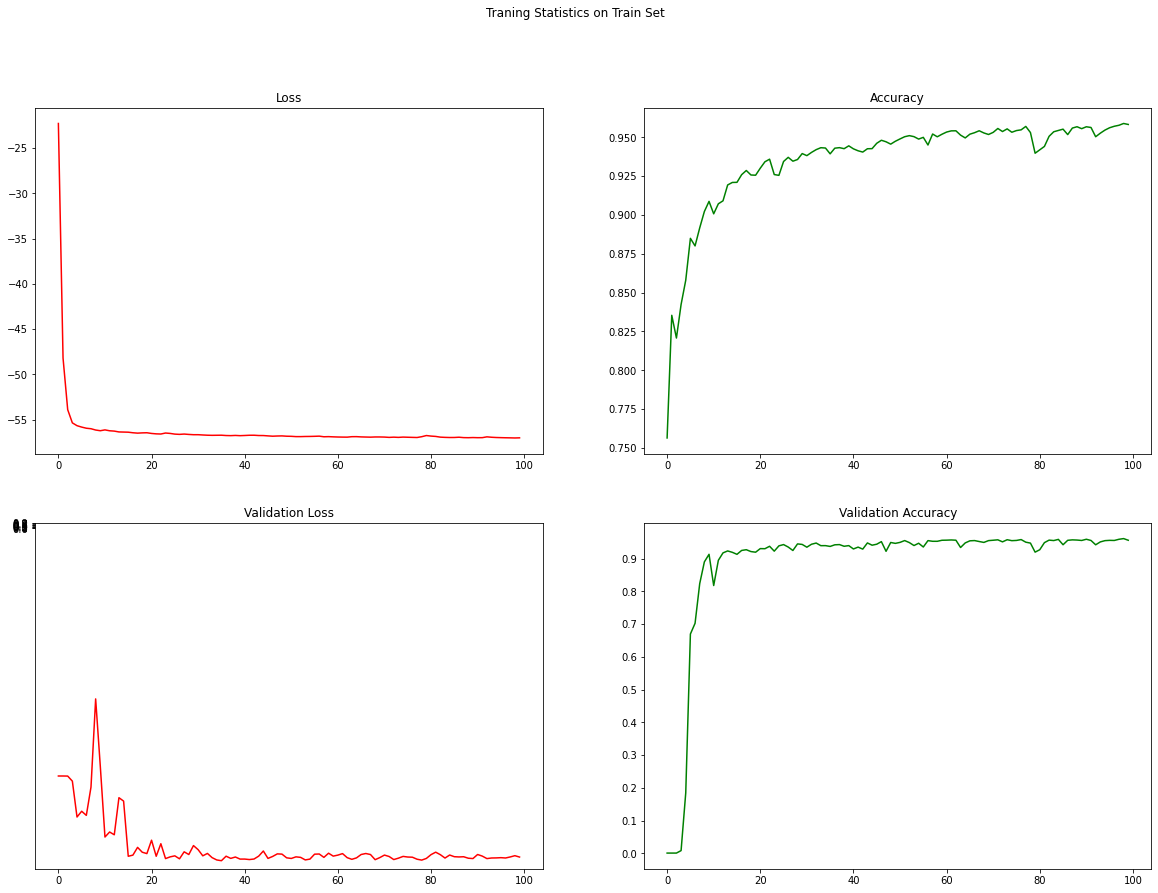

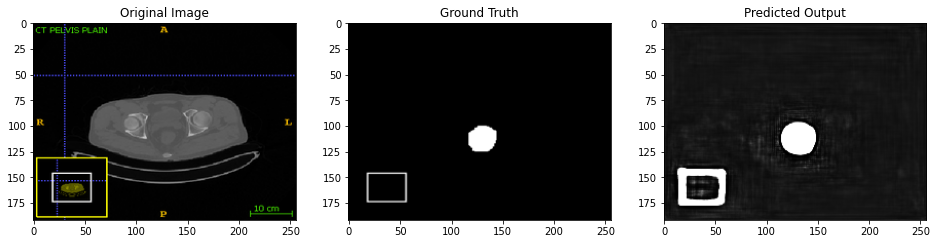

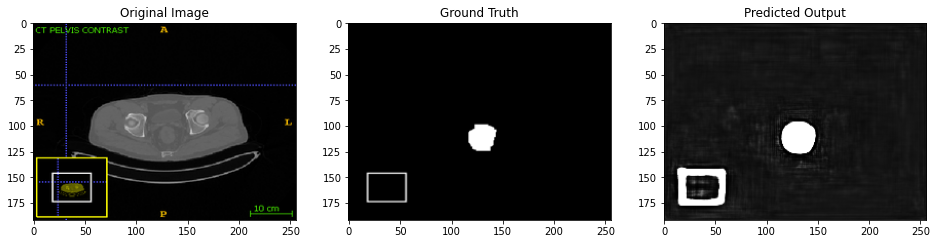

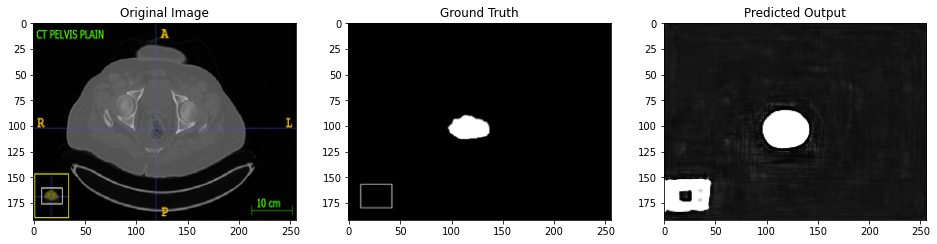

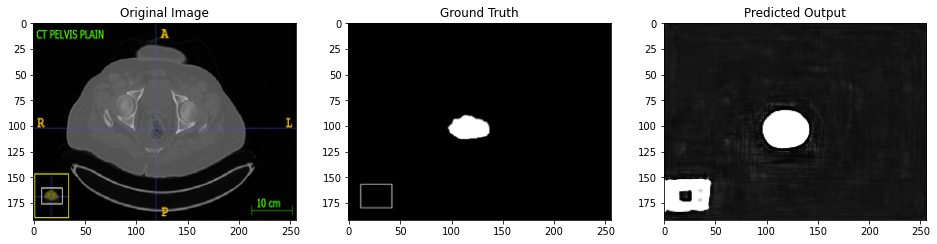

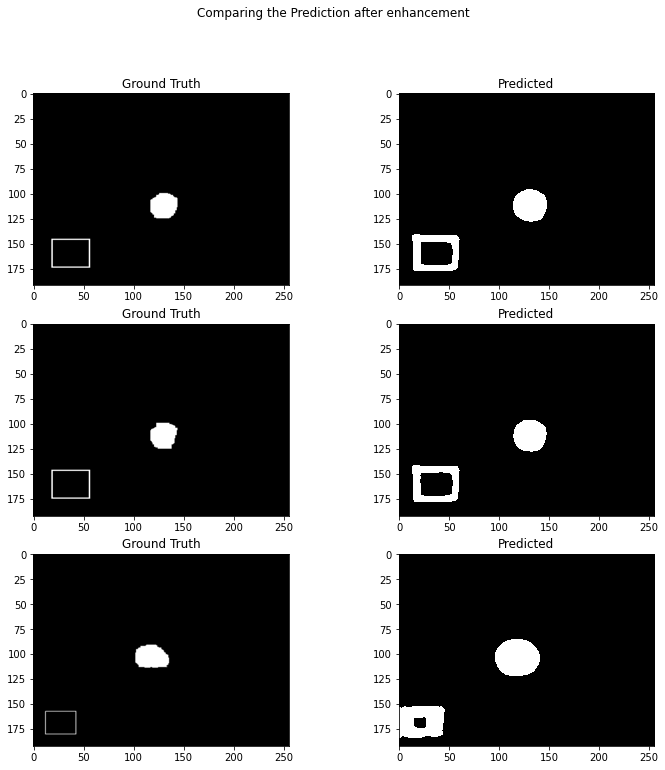

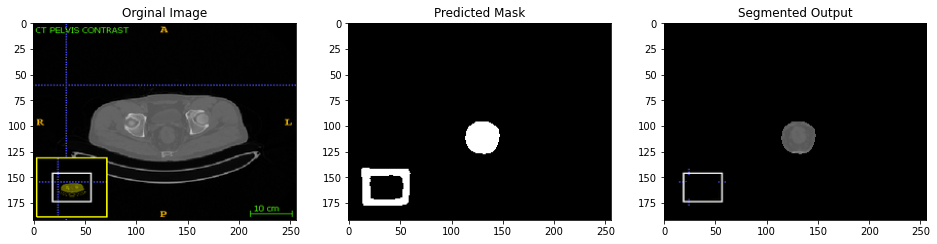

In [ ]:
print ( '\n ˜˜˜˜˜˜˜˜˜˜˜˜˜˜˜ Stats after 100 epoch ˜˜˜˜˜˜˜˜˜˜˜˜˜˜˜˜˜˜˜' )
print ( '\n−−−−−−−−−−−−−On Train Set−−−−−−−−−−−−−−−−−−−−−−−−−−\n' )
res = model_100.evaluate (x_train , y_train , batch_size = 18)
print('--------------------')
print('IOU:      | {:.2f} |'.format(res[1]*100))
print('Dice Coef:| {:.2f} |'.format(res[2]*100))
print('Precision:| {:.2f} |'.format(res[3]*100))
print('Recall:   | {:.2f} |'.format(res[4]*100))
print('Accuracy: | {:.2f} |'.format(res[5]*100))
print("Loss:     | {:.2f} |".format(res[0]*100))
print('--------------------')
print('\n_____________On Test Set____________________\n')
res = model_100.evaluate(x_test, y_test, batch_size= 18)
print('-------------------------')
print('IOU:      | {:.2f} |'.format(res[1]*100))
print('Dice Coef:| {:.2f} |'.format(res[2]*100))
print('Precision:| {:.2f} |'.format(res[3]*100))
print('Recall:   | {:.2f} |'.format(res[4]*100))
print('Accuracy: | {:.2f} |'.format(res[5]*100))
print("Loss:     | {:.2f} |".format(res[0]*100))
print('--------------------')
print('\n_____________On validation Set____________________\n')
res = model_100.evaluate(x_val, y_val, batch_size=18)
print('-------------------------')
print('IOU:      | {:.2f} |'.format(res[1]*100))
print('Dice Coef:| {:.2f} |'.format(res[2]*100))
print('Precision:| {:.2f} |'.format(res[3]*100))
print('Recall:   | {:.2f} |'.format(res[4]*100))
print('Accuracy: | {:.2f} |'.format(res[5]*100))
print("Loss:     | {:.2f} |".format(res[0]*100))
print('-------------------------')

plt.figure(figsize=(20,14))
plt.suptitle('Traning Statistics on Train Set')
plt.subplot(2,2,1)
plt.plot(hist.history['loss'], 'red')
plt.title('Loss')
plt.subplot(2,2,2)
plt.plot(hist.history['accuracy'], 'green')
plt.title('Accuracy')
plt.subplot(2,2,3)
plt.plot(hist.history['val_loss'], 'red')
plt.yticks(list(np.arange(0.0, 1.0, 0.10)))
plt.title('Validation Loss')
plt.subplot(2,2,4)
plt.plot(hist.history['val_accuracy'], 'green')
plt.yticks(list(np.arange(0.0, 1.0, 0.10)))
plt.title('Validation Accuracy')
plt.show()

img_num=1
img_pred = model_100.predict(x_test[img_num].reshape(1,192,256,3))
plt.figure(figsize =(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(192,256), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

img_num=2
img_pred = model_100.predict(x_test[img_num].reshape(1,192,256,3))
plt.figure(figsize =(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(192,256), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

img_num=0
img_pred = model_100.predict(x_test[img_num].reshape(1,192,256,3))
plt.figure(figsize =(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(192,256), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

img_num=0
img_pred = model_100.predict(x_test[img_num].reshape(1,192,256,3))
plt.figure(figsize =(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(192,256), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

def enhance(img):
    sub= (model_100.predict(img.reshape(1,192,256,3))).flatten()

    for i in range(len(sub)):
      if sub[i]>0.5:
          sub[i] = 1
      else:
          sub[i] = 0
    return sub


plt.figure(figsize=(12,12))
plt.suptitle('Comparing the Prediction after enhancement')
plt.subplot(3,2,1)
plt.imshow(y_test[1], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,2)
plt.imshow(enhance(x_test[1]).reshape(192,256), plt.cm.binary_r)
plt.title('Predicted')
plt.subplot(3,2,3)
plt.imshow(y_test[2], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,4)
plt.imshow(enhance(x_test[2]).reshape(192,256), plt.cm.binary_r)
plt.title('Predicted')
plt.subplot(3,2,5)
plt.imshow(y_test[3], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,6)
plt.imshow(enhance(x_test[3]).reshape(192,256), plt.cm.binary_r)
plt.title('Predicted')
plt.show()

def applyMask(img_num):
    img = x_test[img_num]
    mask = np.array(enhance(img).reshape(192,256), dtype=np.uint8)
    res = cv2.bitwise_and(img, img, mask = mask)

    return res

img_num = 2
masked_img = applyMask(img_num)
plt.figure(figsize =(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Orginal Image')
plt.subplot(1,3,2)
plt.imshow(enhance(x_test[img_num]).reshape(192,256), plt.cm.binary_r)
plt.title('Predicted Mask')
plt.subplot(1,3,3)
plt.imshow(masked_img, plt.cm.binary_r)
plt.title('Segmented Output')
plt.show()